In [1]:
# import linecache
# import numpy as np
# def load_raw_audio(size):
#     audio=[]
#     filenames=[]
#     transcript=[]
#     for speaker in os.listdir("../dataset/dev/dev-clean/"):
#         for chapter in os.listdir("../dataset/dev/dev-clean/"+speaker):
#             for filename in os.listdir("../dataset/dev/dev-clean/"+speaker+"/"+chapter):
#                 if filename.endswith(".flac"):
#                     audio.append(spectrogram_from_file("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+filename))
#                     line = linecache.getline("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+"".join(list(filename)[:-10])+".trans.txt", int("".join(list("".join(list(filename)[:-5]))[-4:]))+1)
#                     transcript.append(line)
#                     filenames.append("".join(list(filename)[:-5]))
#                 if len(audio)>size:
#                     break
#     return audio,filenames,transcript

In [2]:
# def transcript_cleaner(transcript):
#     for i in range(len(transcript)):
#         transcript[i]=transcript[i].split(' ',1)[1]
# transcript_cleaner(trans_dev)

In [1]:
# def transcript_to_index(transcript):
#     transcript_to_index=[]
#     for line in transcript:
#         line_to_index=[]
#         for character in list(line)[:-1]:
#             if character==' ':
#                 character='<SPACE>'
#             line_to_index.append(char_map[character])
#         transcript_to_index.append(line_to_index)
#     return transcript_to_index

In [1]:
char_map_str = """
' 1
<SPACE> 2
A 3
B 4
C 5
D 6
E 7
F 8
G 9
H 10
I 11
J 12
K 13
L 14
M 15
N 16
O 17
P 18
Q 19
R 20
S 21
T 22
U 23
V 24
W 25
X 26
Y 27
Z 28
"""
char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch
index_map[2] = ' '

In [2]:
from numpy.lib.stride_tricks import as_strided
import soundfile
from matplotlib import pyplot as plt
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):

    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [3]:
def spectrogram_from_file(filename ,aug='og',step=10, window=20, max_freq=None,
                          eps=1e-14,input_length=400000):
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        
        if len(audio)>input_length:
            audio = audio[:input_length]
        else:
            audio = np.pad(audio, (0, max(0, input_length - len(audio))), "constant")
        
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq must not be greater than half of "
                             " sample rate")
        if step > window:
            raise ValueError("step size must not be greater than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        if aug=='noise':
            RMS=np.sqrt(np.mean(audio**2))
            noise=np.random.normal(0, RMS, audio.shape[0])/30
            audio+=noise
            pxx, freqs = spectrogram(audio, fft_length=fft_length, sample_rate=sample_rate,hop_length=hop_length)
        elif aug=='og':
            pxx, freqs = spectrogram(audio, fft_length=fft_length, sample_rate=sample_rate,hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
        spec=np.transpose(np.log(pxx[:ind, :] + eps))

    return spec

In [4]:
import linecache
import numpy as np
import pandas as pd
def load_all_data():
    #audio=[]
    #filenames=[]
    #transcript=[]
    data=[]
    max_len=0
    for speaker in os.listdir("../dataset/dev/dev-clean/"):
        for chapter in os.listdir("../dataset/dev/dev-clean/"+speaker):
            for filename in os.listdir("../dataset/dev/dev-clean/"+speaker+"/"+chapter):
                if filename.endswith(".flac"):
                    #audio.append(spectrogram_from_file("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+filename))
                    line = linecache.getline("./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+"".join(list(filename)[:-10])+".trans.txt", int("".join(list("".join(list(filename)[:-5]))[-4:]))+1)
                    #transcript.append(line)
                    #filenames.append("".join(list(filename)[:-5]))
                    source="./../dataset/dev/dev-clean/"+speaker+"/"+chapter+"/"+filename
                    sample=(source,line)
                    data.append(sample)
                    max_len=max(max_len,len(list(line[:-1])))
    #df = pd.DataFrame(data, columns = ['source','transcript'])
    #print(max_len)
    return data

In [5]:
def process_input_file(sample,aug,max_len=500):
    source,transcript=sample
    
    transcript=transcript.split(' ',1)[1]
    # print(transcript)
    # print(source)
    line_to_index=[]
    for character in list(transcript)[:-1]:
        if character==' ':
                character='<SPACE>'
        line_to_index.append(char_map[character])
    
    if len(line_to_index)>=500:
        line_to_index=line_to_index[:500]
    else:
        while len(line_to_index)<500:
            line_to_index.append(2)
    spec=spectrogram_from_file(source,aug)
    size=len(line_to_index)
    processed_input=(spec,np.array(line_to_index),spec.shape[0],size)
    return processed_input

2703
./../dataset/dev/dev-clean/8842/302196/8842-302196-0005.flac
(500,)
[17  8 22  7 16  2 25 17 23 14  6  2 10  7  2  3 24  3 11 14  2 10 11 15
 21  7 14  8  2 17  8  2  3 16 27  2 21 18  7  5 11  3 14  2  9 20  3  5
  7  2 17  8  2 10 11 21  2 17 25 16  2 11  6 11 17 15  2  3 16  6  2  7
 18 17  5 10  2 11  8  2 17 16 14 27  2 10 11 21  2 25 11 14 14  2  4  7
 14 17 16  9  7  6  2 22 17  2 10 11 15  2 17  8 22  7 16  2 25 17 23 14
  6  2 21 17 15  7  2  5  3  6  7 16  5  7  2 21  7 20 24  7  2 10 11 15
  2  4 23 22  2  8 17 20  2 10 11 21  2  3 23 22 10 17 20  1 21  2 21 22
 20 23  5 22 23 20  7  2 21 17 15  7  2 21 22 20 23  5 22 23 20  7  2  4
 23 22  2  8 17 20  2 10 11 21  2  3 23 22 10 17 20  1 21  2  5  3  6  7
 16  5  7  2 17  8 22  7 16  2 22 10  7  2  4  7  3 23 22 11  8 23 14  2
 22 23 20 16  2 17  8  2  3  2 21 22  3 16 28  3  2 15 23 21 22  2  4  7
  2 25  7  3 13  7 16  7  6  2 22 17  2  3  6 17 18 22  2 21 17 15  7  2
 20 10 27 15  7  2 25 10 11  5 10  2 25 11 14 14  2

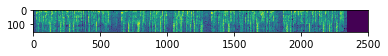

In [6]:
data=load_all_data()
print(len(data))
print(data[0][0])
spec,text,time,size=process_input_file(data[0],aug='og')
print(np.shape(text))
print(text)
plt.imshow(np.transpose(spec))
print(spec.shape)
print(time)
print(size)

2703
./../dataset/dev/dev-clean/8842/302196/8842-302196-0005.flac
(500,)
[17  8 22  7 16  2 25 17 23 14  6  2 10  7  2  3 24  3 11 14  2 10 11 15
 21  7 14  8  2 17  8  2  3 16 27  2 21 18  7  5 11  3 14  2  9 20  3  5
  7  2 17  8  2 10 11 21  2 17 25 16  2 11  6 11 17 15  2  3 16  6  2  7
 18 17  5 10  2 11  8  2 17 16 14 27  2 10 11 21  2 25 11 14 14  2  4  7
 14 17 16  9  7  6  2 22 17  2 10 11 15  2 17  8 22  7 16  2 25 17 23 14
  6  2 21 17 15  7  2  5  3  6  7 16  5  7  2 21  7 20 24  7  2 10 11 15
  2  4 23 22  2  8 17 20  2 10 11 21  2  3 23 22 10 17 20  1 21  2 21 22
 20 23  5 22 23 20  7  2 21 17 15  7  2 21 22 20 23  5 22 23 20  7  2  4
 23 22  2  8 17 20  2 10 11 21  2  3 23 22 10 17 20  1 21  2  5  3  6  7
 16  5  7  2 17  8 22  7 16  2 22 10  7  2  4  7  3 23 22 11  8 23 14  2
 22 23 20 16  2 17  8  2  3  2 21 22  3 16 28  3  2 15 23 21 22  2  4  7
  2 25  7  3 13  7 16  7  6  2 22 17  2  3  6 17 18 22  2 21 17 15  7  2
 20 10 27 15  7  2 25 10 11  5 10  2 25 11 14 14  2

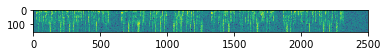

In [7]:
data=load_all_data()
print(len(data))
print(data[0][0])
spec,text,time,size=process_input_file(data[0],aug='noise')
print(np.shape(text))
print(text)
plt.imshow(np.transpose(spec))
print(spec.shape)
print(time)
print(size)

In [10]:
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,batch_size=256,shuffle=True,dim=(2499,161)):
        'Initialization'
       
        self.batch_size = batch_size
        self.shuffle = shuffle        
        self.data=data
        self.data=load_all_data()
        self.list_IDs = np.arange(len(self.data))
        self.on_epoch_end()
        self.dim=dim
        self.cur_index=0

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.list_IDs / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size//2:(index+1)*self.batch_size//2]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs for k in indexes]

        # Generate data
        X, y,input_length,label_length = self.__data_generation(list_IDs_temp)
        inputs = {
            'the_input': X,
            'the_labels': y,
            'input_length': input_length,
            'label_length': label_length,
        }

        outputs = {'ctc': np.zeros([self.batch_size])}

        return (inputs, outputs)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = self.list_IDs
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size,500),dtype='int8')
        input_length=[]
        label_length=[]
        for i, ID in enumerate(list_IDs_temp):
            x,y,t,s=process_input_file(self.data[i],aug='og')
            X[i,]=x
            Y[i,]=y 
            input_length.append(t)
            label_length.append(s)
        i+=1
        for j,ID in enumerate(list_IDs_temp):
            x,y,t,s=process_input_file(self.data[j],aug='noise')
            X[j+i,]=x
            Y[j+i,]=y 
            input_length.append(t)
            label_length.append(s)
        input_length = np.array(input_length)
        label_length= np.array(label_length)
        return X,Y,input_length,label_length
    def next_batch(self):
        while 1:
            if (self.cur_index + 1) * self.batch_size >= len(self.data) - self.batch_size:

                self.cur_index = 0

            try:
                ret = self.__getitem__(self.cur_index)
            except:
                print("data error - this shouldn't happen - try next batch")
                self.cur_index += 1
                ret = self.__getitem__(self.cur_index)

            self.cur_index += 1

            yield ret

In [11]:
train_gen=DataGenerator(batch_size=32)
inp,oup=train_gen.__getitem__(0)
dat=train_gen.next_batch()

In [13]:
print(np.shape(inp['the_input']),np.shape(inp['the_labels']))

(32, 2499, 161) (32, 500)


[17  8 22  7 16  2 25 17 23 14  6  2 10  7  2  3 24  3 11 14  2 10 11 15
 21  7 14  8  2 17  8  2  3 16 27  2 21 18  7  5 11  3 14  2  9 20  3  5
  7  2 17  8  2 10 11 21  2 17 25 16  2 11  6 11 17 15  2  3 16  6  2  7
 18 17  5 10  2 11  8  2 17 16 14 27  2 10 11 21  2 25 11 14 14  2  4  7
 14 17 16  9  7  6  2 22 17  2 10 11 15  2 17  8 22  7 16  2 25 17 23 14
  6  2 21 17 15  7  2  5  3  6  7 16  5  7  2 21  7 20 24  7  2 10 11 15
  2  4 23 22  2  8 17 20  2 10 11 21  2  3 23 22 10 17 20  1 21  2 21 22
 20 23  5 22 23 20  7  2 21 17 15  7  2 21 22 20 23  5 22 23 20  7  2  4
 23 22  2  8 17 20  2 10 11 21  2  3 23 22 10 17 20  1 21  2  5  3  6  7
 16  5  7  2 17  8 22  7 16  2 22 10  7  2  4  7  3 23 22 11  8 23 14  2
 22 23 20 16  2 17  8  2  3  2 21 22  3 16 28  3  2 15 23 21 22  2  4  7
  2 25  7  3 13  7 16  7  6  2 22 17  2  3  6 17 18 22  2 21 17 15  7  2
 20 10 27 15  7  2 25 10 11  5 10  2 25 11 14 14  2 22  3 14 14 27  2  3
 16  6  2 10  7  2 21  7  7 21  2 22 10  7  2 18 17

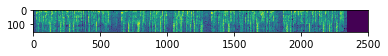

In [14]:
print(inp['the_labels'][0])
plt.imshow(np.transpose(inp['the_input'][0]))

[22 10  7  2 14 11  8  7  2  4 14 17 17  6  2 17  8  2 20 10 27 22 10 15
 11  5  3 14  2 22 20  3 16 21 14  3 22 11 17 16  2 11 21  2 22 10 11 21
  2  5 17 15 15  3 16  6 15  7 16 22  2 22 10  3 22  2  3  2  9 17 17  6
  2 18 17  7 15  2 21 10  3 14 14  2 16 17 22  2  4  7  2 22 23 20 16  7
  6  2 11 16 22 17  2  3  2  4  3  6  2 17 16  7  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2

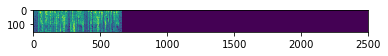

In [15]:
print(inp['the_labels'][9])
plt.imshow(np.transpose(inp['the_input'][9]))
print(inp['the_input'][9].shape)

In [16]:
input_dim=161
fc_size=1024
rnn_size=512
output_dim=29
initialization='glorot_uniform'
conv_layers=1
gru_layers=1
use_conv=True

In [17]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.recurrent import SimpleRNN
from keras.layers import Dense, Activation, Bidirectional, Reshape,Flatten, Lambda, Input,\
    Masking, Convolution1D, BatchNormalization, GRU, Conv1D, RepeatVector, Conv2D
from keras.optimizers import SGD, adam, Adam
from keras.layers import ZeroPadding1D, Convolution1D, ZeroPadding2D, Convolution2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import TimeDistributed, Dropout
from keras.layers.merge import add  # , # concatenate BAD FOR COREML
from keras.utils.conv_utils import conv_output_length
from keras.activations import relu
import tensorflow
from keras.models import Sequential
from keras.layers import InputLayer
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    import tensorflow as tf
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [18]:
def ds2_gru_model(input_dim=161, fc_size=1024, rnn_size=512, output_dim=29, initialization='glorot_uniform',
                  conv_layers=1, gru_layers=1, use_conv=True):
    K.set_learning_phase(1)

    input_data = Input(shape=(None, input_dim), name='the_input')
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(input_data)

    if use_conv:
        #conv = ZeroPadding1D(padding=(0, 2048))(x)
        for l in range(conv_layers):
            x = Conv1D(filters=fc_size, name='conv_{}'.format(l+1), kernel_size=11, padding='valid', activation='relu', strides=2)(x)
    else:
        for l in range(conv_layers):
            x = TimeDistributed(Dense(fc_size, name='fc_{}'.format(l + 1), activation='relu'))(x)  # >>(?, time, fc_size)

    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    for l in range(gru_layers):
        x = Bidirectional(GRU(rnn_size, name='fc_{}'.format(l + 1), return_sequences=True, activation='relu', kernel_initializer=initialization),
                      merge_mode='sum')(x)

    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    # Last Layer 5+6 Time Dist Dense Layer & Softmax
    x = TimeDistributed(Dense(fc_size, activation='relu'))(x)
    y_pred = TimeDistributed(Dense(output_dim, name="y_pred", activation="softmax"))(x)

    # labels = K.placeholder(name='the_labels', ndim=1, dtype='int32')
    labels = Input(name='the_labels', shape=[None,], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred,
                                                                       labels,
                                                                       input_length,
                                                                       label_length])

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
    return model

In [19]:
model = ds2_gru_model(input_dim=161, fc_size=1024, rnn_size=512, output_dim=29)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, None, 161)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 161)    644         the_input[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 1024)   1814528     batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, 1024)   4096        conv_1[0][0]                     
____________________________________________________________________________________________

In [21]:
opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, clipnorm=5)

In [22]:
def ctc(y_true, y_pred):
    return y_pred

In [23]:
model.compile(optimizer=opt, loss=ctc)

In [24]:
model.fit_generator(generator=train_gen.next_batch(),
                        epochs=1,
                        initial_epoch=0,
                        verbose=1,
                        steps_per_epoch=1,
                        class_weight=None,
                        max_q_size=10,
                        workers=1,
                        pickle_safe=False
                        )

Epoch 1/1
1/1 [==============================] - 187s 187s/step - loss: inf
